In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.metrics import silhouette_score, adjusted_rand_score

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial attempt at clustering

### Extract Alpha\Delta\Omicron (ADO) Sequences

In [5]:
data_dir = './data/RBD'
meta_data = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]
metadata_df

,seq_id,Pango lineage,Location,Collection date,AA Substitutions
0,EPI_ISL_5120698,B.1.617.2,Europe / Germany / Berlin,2021-10-06,"(NSP1_V54del,NSP3_A1321del,N_G215C,NSP3_S1314d..."
1,EPI_ISL_5123727,AY.4,Europe / United Kingdom / England,2021-10-08,"(N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M..."
2,EPI_ISL_14904955,BA.5.5,North America / USA / Maryland,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
3,EPI_ISL_5119677,AY.126,Europe / Germany / Lower Saxony,2021-09-30,"(N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S..."
4,EPI_ISL_14904971,BA.5.6,North America / USA / California,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
...,...,...,...,...,...
347427,EPI_ISL_14903692,BF.5,North America / USA / California / Alameda County,2022-07-30,"(NSP5_P132H,Spike_H69del,Spike_L24del,NSP3_G48..."
347428,EPI_ISL_14902388,BA.4.6,North America / USA / California,2022-08-22,"(NSP5_P132H,Spike_H69del,Spike_N658S,NSP3_G489..."
347429,EPI_ISL_14905423,BA.5.6,North America / USA / New Jersey,2022-08-22,"(NSP5_P132H,Spike_H69del,Spike_H1058Y,NSP3_G48..."
347430,EPI_ISL_5123715,AY.4,Europe / United Kingdom / England,2021-10-08,"(N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M..."


In [7]:
data_dir = "./data/RBD"
df = pd.read_csv(os.path.join(data_dir, 'spikeprot0528.clean.uniq.noX.RBD_variants.csv'), header=0, na_filter=False)

merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')
merged_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Gamma        5978
Iota         2044
Epsilon      1915
Beta         1342
Lambda        985
Mu            939
Eta           611
Zeta          578
Kappa         505
GH/490R        57
Theta          22
Name: count, dtype: int64

In [8]:
ado_df = merged_df[merged_df['variant'].isin(["Alpha", "Delta", "Omicron"])]
ado_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Name: count, dtype: int64

In [9]:
# Random sampling

min_sample_size = ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [ado_df[ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
sampled_ado_df['variant'].value_counts()

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD_variants-ADO_sampled_seed{rnd_seed}.csv")
sampled_ado_df.to_csv(save_as, index=False)

### Parquet Making

In [11]:
# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, save_as:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
            print(f"CLS SHAPE: {cls_embedding.shape}")
            #output = self.blstm(cls_embedding)
            print(output.shape)
        return cls_embedding

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the ESM model to generate hidden states and store batch data in DataFrame directly. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    batch_dataframes = []

    for _, batch_data in data_iter:
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.cpu().numpy() for embedding in embeddings]  # Convert tensor to numpy array for each embedding
        })

        batch_dataframes.append(batch_df)

    # Concatenate all batch DataFrames into one
    result_df = pd.concat(batch_dataframes, ignore_index=True)
    
    # Save data to a Parquet file
    save_as = csv_file.replace(".csv", "-CLS_embedded.parquet")
    result_df.to_parquet(save_as, index=False)
    print(f"Data saved to {save_as}")

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "./data/RBD"
csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD_variants-ADO_sampled_seed0.csv")
dataset = RBDDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm_version = "facebook/esm2_t6_8M_UR50D"
esm = EsmModel.from_pretrained(esm_version, cache_dir='../model_downloads').to(device)
tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../model_downloads')

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|| 0/1035 [00:00<?, ?it/s]

CLS SHAPE: torch.Size([64, 320])


AttributeError: 'ESM' object has no attribute 'blstm'

### Clustering

In [5]:
def plot_hdbscan_comparison(save_as, info_df, embedding_matrix, hdb_labels, data_column):
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette("tab20", n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab20", n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                       c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                       c=[cluster_color_dict[label]], label=f'Cluster {label}',
                       s=50, alpha=0.8, edgecolors='k')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for value in unique_data_values:
        mask = info_df[data_column] == value
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[ground_truth_color_dict[value]], label=value,
                    s=50, alpha=0.8, edgecolors='k')

    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    for ax in axes:
        ax.set_xlabel('Feature 1', fontsize=14)
        ax.set_ylabel('Feature 2', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()

def plot_hdbscan_comparison_ado(save_as, info_df, embedding_matrix, hdb_labels, data_column, colormap):   
    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 
            'Delta': 'tab:blue', 
            'Omicron': 'tab:green'}
    
    variant_labels = sorted(info_df[data_column].unique())
    variant_colors = {}
    
    # Assign colors based on the custom color map (cmap)
    for variant in variant_labels:
        if variant in cmap:
            variant_colors[variant] = cmap[variant]
        else:
            # Dynamically assign a color if the variant isn't in the cmap
            variant_colors[variant] = sns.color_palette("tab20", n_colors=len(variant_labels))[variant_labels.index(variant)]

    # Add the color mapping to the dataframe
    info_df['colors'] = [variant_colors[variant] for variant in info_df[data_column]]

    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(variant_labels)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=40, alpha=0.8, edgecolors='k')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Right subplot: Ground truth with custom variant colors
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for variant in variant_labels:
        mask = info_df[data_column] == variant
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[variant_colors[variant]], label=variant,
                    s=50, alpha=0.8, edgecolors='k')

    ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()

def plot_hdbscan_with_groups(save_as, info_df, embedding_matrix, hdb_labels, data_column, group_column):
    """
    Plots HDBSCAN clusters and ground truth with different shapes for group_column values, 
    including a unified legend for Serotypes and Groups with subtitles.
    
    Args:
    - info_df: DataFrame containing metadata, including the 'data_column' (e.g., 'serotype') and 'group_column' (e.g., 'dataset', 'host').
    - embedding_matrix: The 2D embedding (e.g., UMAP, t-SNE).
    - hdb_labels: Cluster labels from HDBSCAN, with -1 for outliers.
    - data_column: Column name in info_df for color coding (e.g., 'serotype').
    - group_column: Column name in info_df for differentiating groups (e.g., 'dataset', 'host').
    """
    # Color map for ground truth
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette("tab20", n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # Color map for HDBSCAN clusters
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette("tab20", n_colors=len(unique_clusters) - 1)
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are black

    # Marker shapes for different groups
    unique_groups = info_df[group_column].unique()
    markers = ['o', '^', 's', 'p', '*', 'D', 'v', 'P', '.']
    group_marker_dict = dict(zip(unique_groups, markers))

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters (Predicted)
    ax = axes[0]
    ax.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        for group in unique_groups:
            mask = (hdb_labels == label) & (info_df[group_column] == group)
            if label == -1:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c='black', label='Outliers', marker='x', s=35)
            else:
                ax.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                           c=[cluster_color_dict[label]], marker=group_marker_dict[group],
                           label=f'Cluster {label} ({group})', s=50, alpha=0.8, edgecolors='k')

    legend_handles_predicted = []
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='x', color='black', linestyle='none', markersize=7, label='Outliers'))
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_color_dict[label], markersize=10, label=f'Cluster {label}')
        for label in unique_clusters if label != -1
    ]
    legend_handles_predicted.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_predicted += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    # Right subplot: Ground truth
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for value in unique_data_values:
        for group in unique_groups:
            mask = (info_df[data_column] == value) & (info_df[group_column] == group)
            ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[ground_truth_color_dict[value]], marker=group_marker_dict[group],
                        label=f'{value} ({group})', s=50, alpha=0.8, edgecolors='k')

    legend_handles_ground_truth = []    
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ground_truth_color_dict[value], markersize=10, label=value)
        for value in unique_data_values
    ]
    legend_handles_ground_truth.append(plt.Line2D([0], [0], marker='', color='none', label='', markersize=0))  # blank
    legend_handles_ground_truth += [
        plt.Line2D([0], [0], marker=group_marker_dict[group], color='w', markerfacecolor='black', markersize=10, label=group)
        for group in unique_groups
    ]

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    axes[0].legend(handles=legend_handles_predicted, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[1].legend(handles=legend_handles_ground_truth, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()

def plot_from_embedding(save_as, info_df, embedding_matrix, type, color_map):
    embeddings_df = pd.DataFrame(embedding_matrix, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
    df = pd.concat([info_df, embeddings_df], axis=1)

    # Custom color mapping for specified variants  
    variant_labels = sorted(df["variant"].unique())
    colors = sns.color_palette(color_map, len(variant_labels))
    variant_colors = dict(zip(variant_labels, colors))
    df['colors'] = df['variant'].map(variant_colors)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot each variant separately so each can be labeled
    for variant in variant_labels:
        subset = df[df['variant'] == variant]
        plt.scatter(subset['DIM_1'], subset['DIM_2'], c=[variant_colors[variant]], label=variant, s=20, alpha=0.8)

    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')

    # Create a legend
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_as + ".pdf", format="pdf")
    plt.savefig(save_as + ".png", format="png")
    plt.show()


In [6]:
data_dir = './data'
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD_variants-ADO_sampled_seed0-CLS_embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_ado_df["embedding"])
info_df = embedded_ado_df.drop(columns=["embedding"])

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


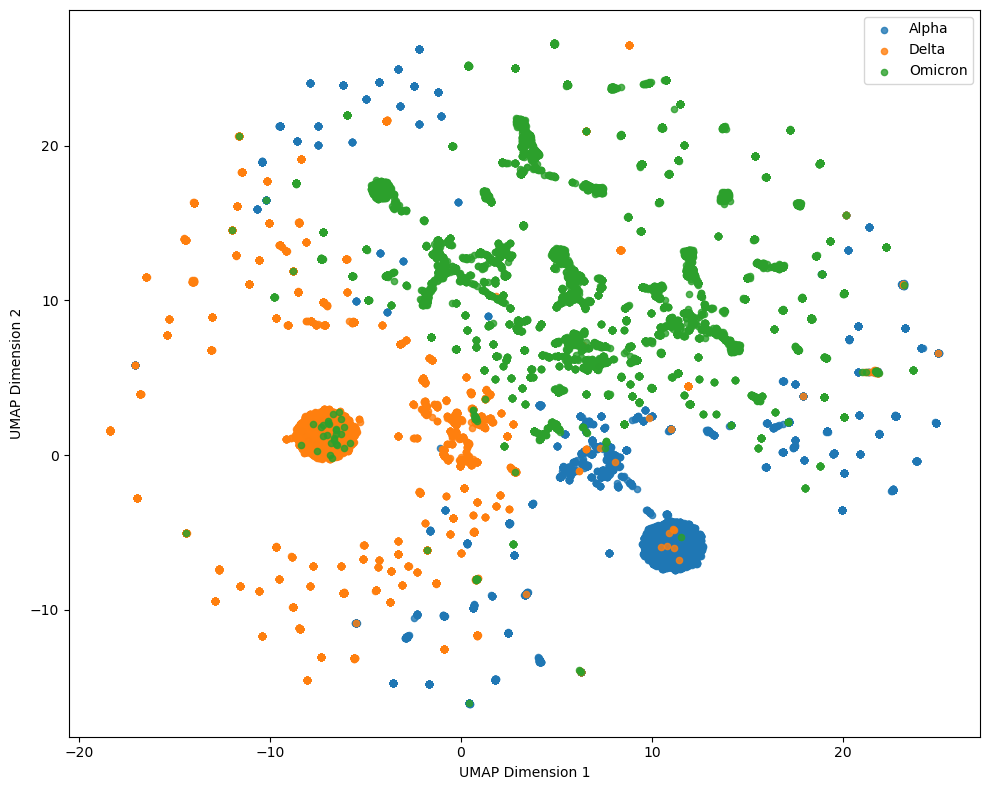

In [9]:
# First, apply UMAP to reduce the dimensionality of the embedding matrix
umap_reducer = UMAP(n_components=2, random_state=0) 
embedding_matrix_reduced = umap_reducer.fit_transform(embedding_matrix)

save_as = f"./plots/rbd_ado-umap"
plot_from_embedding(save_as, info_df, embedding_matrix_reduced, 'UMAP', "tab10")

3 A & B

min_sample 40, min_cluster_size 15000: Silhouette Coefficient: 0.43, Adjusted Rand Index: 0.54


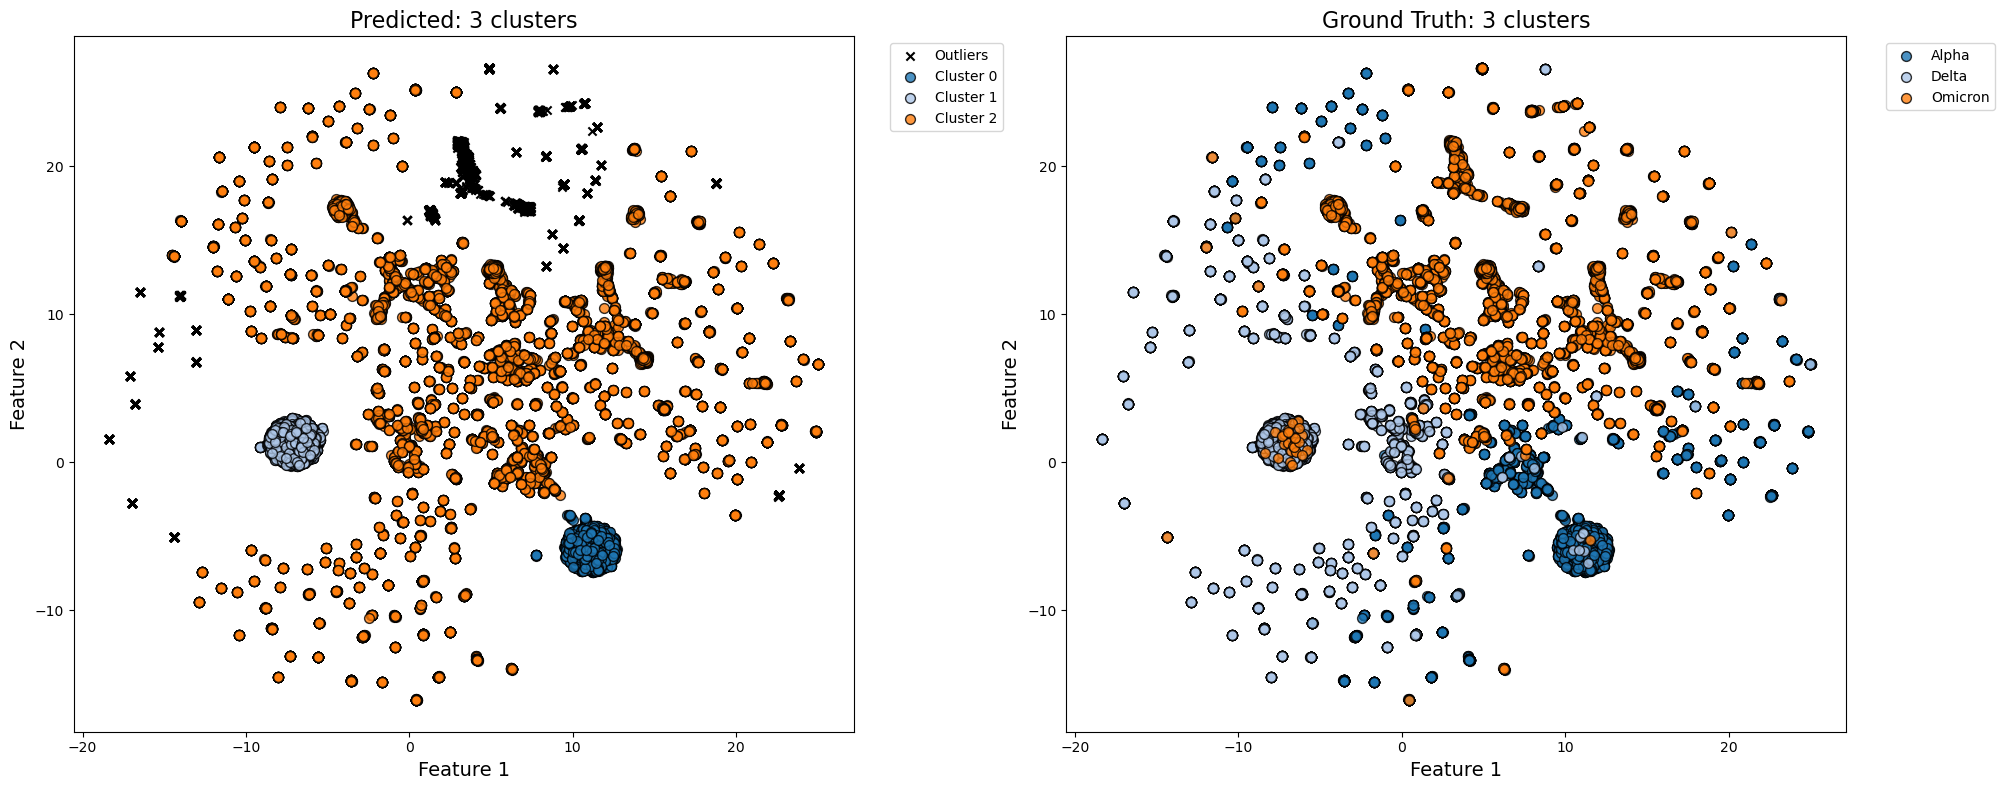

In [10]:
min_samples=40
min_cluster_size=15000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"./plots/rbd_ado-umap_hdbscan-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg}_ari{ari}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant")

min_sample 35, min_cluster_size 16000: Silhouette Coefficient: 0.43, Adjusted Rand Index: 0.54


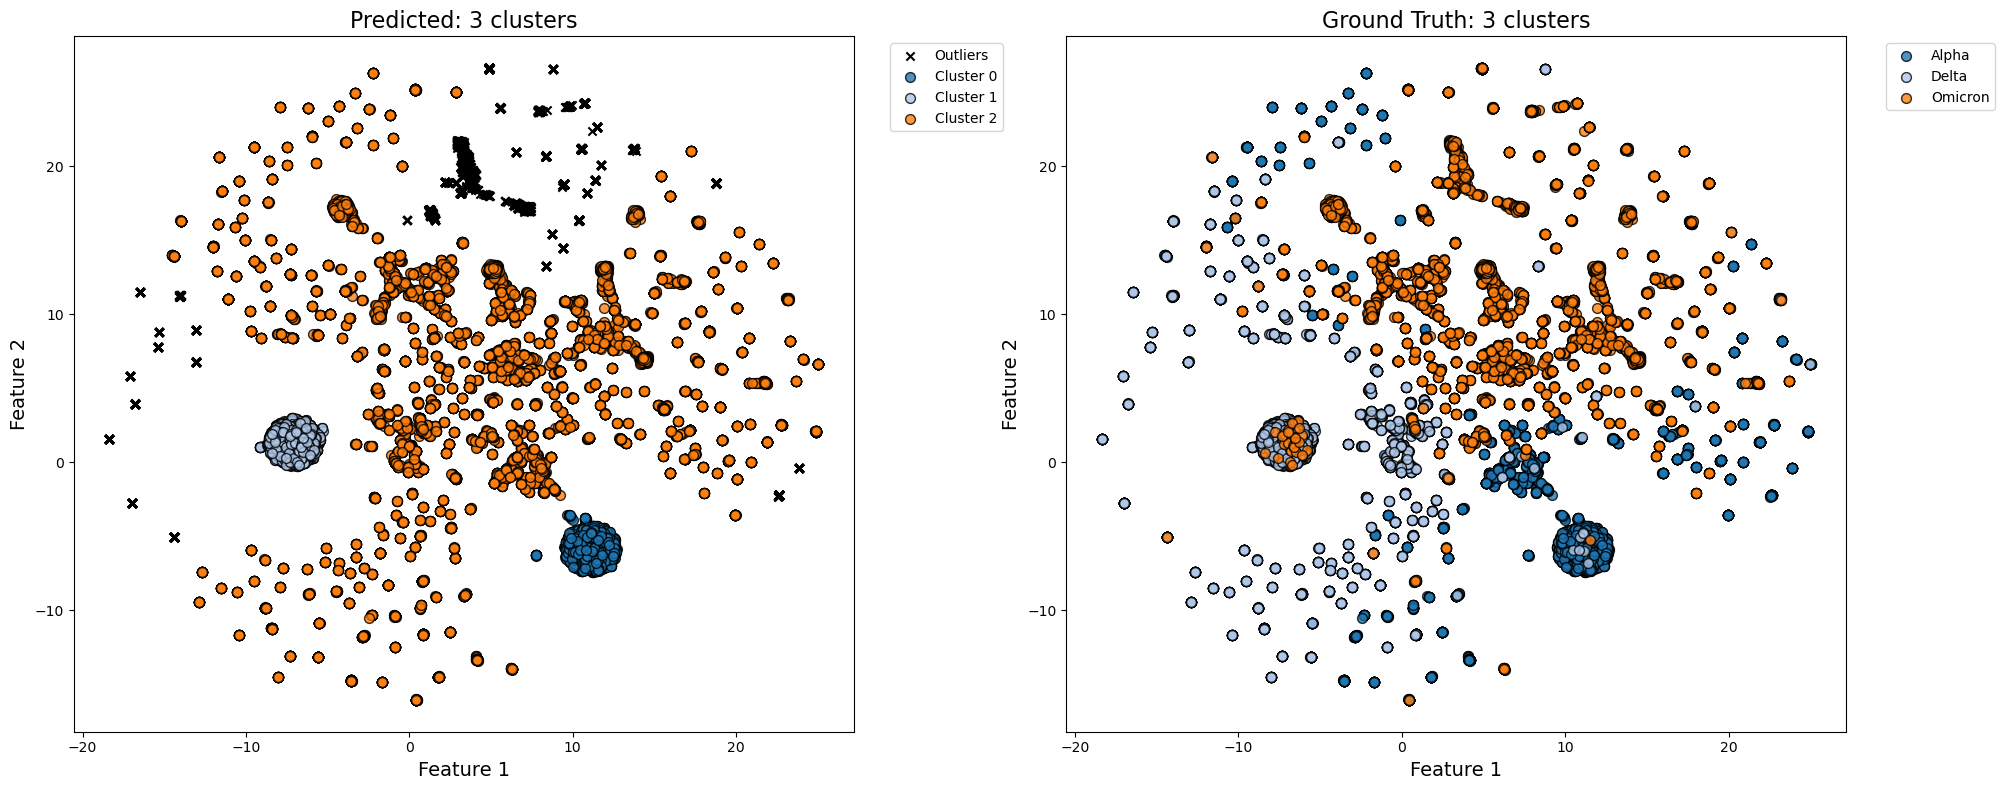

In [11]:
min_samples=35
min_cluster_size=16000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"./plots/rbd_ado-umap_hdbscan-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg}_ari{ari}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant")

We can try UMAP, then HDBSCAN.

In [34]:
for i in [20, 25]:
    for j in [100, 200]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 20, min_cluster_size 100: (Silhouette Coefficient 0.68, Adjusted Rand Index 0.49)
min_sample 20, min_cluster_size 200: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.49)
min_sample 25, min_cluster_size 100: (Silhouette Coefficient 0.69, Adjusted Rand Index 0.49)
min_sample 25, min_cluster_size 200: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.49)


In [1]:
for i in [20, 25, 30, 35]:
    for j in [20000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

NameError: name 'hdbscan' is not defined

In [36]:
for i in [5, 10, 15, 20, 25, 30, 35]:
    for j in [2000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 2000: (Silhouette Coefficient 0.50, Adjusted Rand Index 0.49)
min_sample 10, min_cluster_size 2000: (Silhouette Coefficient 0.44, Adjusted Rand Index 0.48)
min_sample 15, min_cluster_size 2000: (Silhouette Coefficient 0.51, Adjusted Rand Index 0.49)
min_sample 20, min_cluster_size 2000: (Silhouette Coefficient 0.51, Adjusted Rand Index 0.49)
min_sample 25, min_cluster_size 2000: (Silhouette Coefficient 0.47, Adjusted Rand Index 0.48)
min_sample 30, min_cluster_size 2000: (Silhouette Coefficient 0.50, Adjusted Rand Index 0.49)
min_sample 35, min_cluster_size 2000: (Silhouette Coefficient 0.49, Adjusted Rand Index 0.50)


In [18]:
for i in [5, 10, 15, 20, 25, 30, 35]:
    for j in [15000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 15000: (Silhouette Coefficient 0.18, Adjusted Rand Index 0.33)
min_sample 10, min_cluster_size 15000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.33)
min_sample 15, min_cluster_size 15000: (Silhouette Coefficient 0.46, Adjusted Rand Index 0.54)
min_sample 20, min_cluster_size 15000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.58)
min_sample 25, min_cluster_size 15000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.58)
min_sample 30, min_cluster_size 15000: (Silhouette Coefficient 0.46, Adjusted Rand Index 0.59)
min_sample 35, min_cluster_size 15000: (Silhouette Coefficient 0.46, Adjusted Rand Index 0.59)


In [19]:
for i in [5]:
    for j in [10000, 15000, 16000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 10000: (Silhouette Coefficient 0.43, Adjusted Rand Index 0.53)
min_sample 5, min_cluster_size 15000: (Silhouette Coefficient 0.18, Adjusted Rand Index 0.33)
min_sample 5, min_cluster_size 16000: (Silhouette Coefficient 0.18, Adjusted Rand Index 0.33)


Side note, I have tried setting min_cluster_size close to the value of the number of samples per variant (trying to capture this clustering) and this achieves high ARI score. This makes some sense since min_cluster_size is the minimum number of points to form a cluster; setting it close to the sample per variant alreadu matches the natural grouping structure of the data. So I am going to adjust the min_samples to see if we can't get an even better SC/ARI.

SC shows how:
- Clusters are well-separated (points in different clusters are far apart).
- Points within the same cluster are tightly grouped (points within a cluster are close together).

In a sense, a higher min_samples should mean tighter clusters, higher SC. So need the best balance between SC and ARI.